In [ ]:
import math
import pandas as pd
import numpy as np

# Visualization tool

In [320]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.parents:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.creation_op:
            dot.node(name=str(id(n)) + n.creation_op, label=n.creation_op)
            dot.edge(str(id(n)) + n.creation_op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.creation_op)

    return dot

# implementin 

In [321]:
class Tensor:
    def __init__(self, data, parents=[], creation_op=None, label = None):
        self.data = data
        self.grad = 0.0
        self.parents = parents
        self.creation_op = creation_op
        self.label = label
        self._backward = lambda : None

    def zero_grad(self):
        self.grad = 0.0


    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)


        result_data = Tensor(self.data + other.data, parents=[self, other], creation_op="add")


        def backward():
            self.grad += 1 * result_data.grad
            other.grad += 1 * result_data.grad

        result_data._backward = backward


        return result_data


    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data - other.data, parents=[self, other], creation_op="sub")

        def backward():
            self.grad += 1 * result_data.grad
            other.grad += -1 * result_data.grad

        result_data._backward = backward

        return result_data


    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data * other.data, parents=[self, other], creation_op="mul")

        def backward():
            self.grad += other.data * result_data.grad
            other.grad += self.data * result_data.grad

        result_data._backward = backward

        return result_data

    def __truediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data / other.data, parents=[self, other], creation_op="div")

        def backward():
            self.grad += 1 / other.data * result_data.grad
            other.grad += - (self.data / (other.data ** 2)) * result_data.grad

        result_data._backward = backward

        return result_data

    def __repr__(self) -> str:
        return f"Tensor(data={self.data}, grad={self.grad})"


    def __pow__(self, other):
        result_data = Tensor(self.data ** other, parents=[self], creation_op="pow_two")

        def backward():
            self.grad += other * (self.data ** (other - 1)) * result_data.grad

        result_data._backward = backward

        return result_data


    def backward(self):
        self.grad = 1
        topo = self.topological_sort()

        for tensor in topo:
            tensor._backward()



    def topological_sort(self):

        topo = []
        visited = set()

        def dfs(tensor):
            if tensor not in visited:
                visited.add(tensor)
                for parent in tensor.parents:
                    dfs(parent)
                topo.append(tensor)

        dfs(self)
        return topo[::-1]

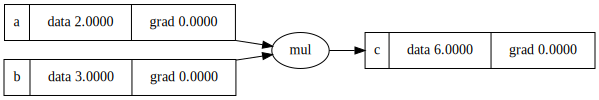

In [322]:
a = Tensor(2, label='a')
b = Tensor(3, label='b')

c = a * b; c.label = 'c'
draw_dot(c)

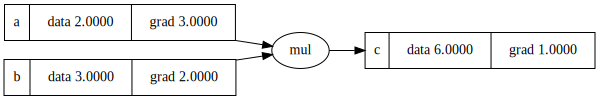

In [323]:
c.backward()

draw_dot(c)

In [324]:
class F:
    @staticmethod
    def tanh(x):
        if isinstance(x, Tensor):
            result_data = Tensor(math.tanh(x.data), parents=[x], creation_op="tanh")

            def backward():
                x.grad += (1 - math.tanh(x.data) ** 2) * result_data.grad

            result_data._backward = backward

            return result_data


In [325]:
import random

In [326]:
class Neuron:
    def __init__(self, input_size):
        self.weights = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]
        self.bias = Tensor(random.uniform(-1, 1))
    def forward(self, x):
        res = self.bias
        for w_i, x_i in zip(self.weights, x):
            res += w_i * x_i
        return F.tanh(res)

    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        return self.weights + [self.bias]

In [327]:
class Layer:
    def __init__(self, input_size, output_size):
        self.neurons = [Neuron(input_size) for _ in range(output_size)]
    def forward(self, x):
        res = [neuron(x) for neuron in self.neurons]
        return res[0] if len(res) == 1 else res
    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params += neuron.parameters()
        return params

In [328]:
class MLP:
    def __init__(self, input_size, layer_sizes):
        layer_total = [input_size] + layer_sizes
        self.layers = [Layer(layer_total[i], layer_total[i + 1]) for i in range(len(layer_sizes))]
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params

In [329]:
class Optimizer:

    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()

    def step(self):
        for param in self.parameters:
            param.data -= param.grad * self.lr


In [330]:
def make_predictions(model, X):
    preds = []
    for x in X:
        pred = model(x)
        preds.append(pred)
    return preds

In [331]:
def calculate_loss(y_true, y_pred):

    loss = Tensor(0)

    for y_t, y_p in zip(y_true, y_pred):
        loss += (y_p - y_t) ** 2

    return loss / len(y_true)

# Testing

In [ ]:
df = pd.read_csv("./iris.csv")
df

In [ ]:
variety_encoding = {"Setosa":1,"Versicolor":2,"Virginica":3}
df["variety"] = df["variety"].apply(variety_encoding.get)
df

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
min_max_df = min_max_scaler.fit_transform(df)
new_df = pd.DataFrame(min_max_df)
new_df

In [ ]:
y = new_df[4]
X = new_df.drop(4, axis=1)


In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [ ]:
input_size = 4 # Number of features in the input layer
layer_sizes = [4, 1] # Number of neurons in each hidden and output layer

model = MLP(input_size, layer_sizes)

params = model.parameters()

optim = Optimizer(params, 0.3)


In [ ]:
n_epochs = 2000


for i in range(n_epochs):

    y_hats = make_predictions(model, X)

    loss = calculate_loss(y, y_hats)

    optim.zero_grad()

    loss.backward()

    optim.step()

    print(f"loss in iteration {i}: {loss}")


In [ ]:
t_arr = []
for i in range(len(X_test)):
    output = model(X_test[i])
    t_arr.append(output)
    print(output, " label: ",y_test[i])

In [ ]:
y_pred = []
for t in t_arr:
    y_pred.append(t.data)
y_pred = np.array(y_pred)
y_pred

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

In [332]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=900, centers=3, n_features=2, random_state=0)


In [333]:
y = np.where(y == 0, -1, y)
y = np.where(y == 1, 0, y)
y = np.where(y == 2, 1, y)


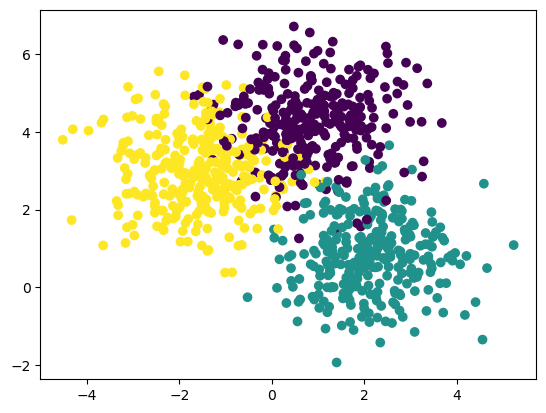

In [334]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [335]:
input_size = 2 # Number of features in the input layer
layer_sizes = [2, 2, 1] # Number of neurons in each hidden and output layer

model = MLP(input_size, layer_sizes)

params = model.parameters()

optim = Optimizer(params, 0.3)


In [336]:
n_epochs = 1000


for i in range(n_epochs):

    y_hats = make_predictions(model, X)

    loss = calculate_loss(y, y_hats)

    optim.zero_grad()

    loss.backward()

    optim.step()

    print(f"loss in iteration{i}: {loss}")


loss in iteration0: Tensor(data=0.857468504829897, grad=1)
loss in iteration1: Tensor(data=0.8571579045140006, grad=1)
loss in iteration2: Tensor(data=0.8568475168483365, grad=1)
loss in iteration3: Tensor(data=0.8565373426219152, grad=1)
loss in iteration4: Tensor(data=0.8562273826221646, grad=1)
loss in iteration5: Tensor(data=0.8559176376349124, grad=1)
loss in iteration6: Tensor(data=0.8556081084443795, grad=1)
loss in iteration7: Tensor(data=0.8552987958331645, grad=1)
loss in iteration8: Tensor(data=0.8549897005822387, grad=1)
loss in iteration9: Tensor(data=0.8546808234709319, grad=1)
loss in iteration10: Tensor(data=0.8543721652769145, grad=1)
loss in iteration11: Tensor(data=0.8540637267762029, grad=1)
loss in iteration12: Tensor(data=0.8537555087431308, grad=1)
loss in iteration13: Tensor(data=0.8534475119503467, grad=1)
loss in iteration14: Tensor(data=0.8531397371688008, grad=1)
loss in iteration15: Tensor(data=0.8528321851677395, grad=1)
loss in iteration16: Tensor(data=0.